In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dizzy_util as util
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 150)

In [3]:
dataset = util.extractDataset("B00_ML4TrgPos_", {"WithRole", "AllMed", "Vital", "HF", "DispensedDrug"})

C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_30_Note_WithRole,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_30_Note,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_DispensedDrug,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE


C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\VHAHOUWuY1\AppData\

dict_keys(['cohort', 'Rad', 'Note', 'Lab', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD', 'new', 'Demorgraphics', 'Only10daysPrior30DaysAfter'])


In [4]:
dizziness_df, label_map = util.retrieveLabels() # labeled
label_df = util.convertLabelMap(label_map) # PatientSSN | Label (100)
datasubset = util.extractAndStandarizeCohort(dataset, "Dizziness") # dataset for dizziness (All).
edstart = util.extractFirstVisitIndexDatetime(datasubset["cohort"]) # get first entry of each patient.

In [5]:
dizziness_df["DxErrorERCoded"].value_counts()

NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: DxErrorERCoded, dtype: int64

In [6]:
datasubset["cohort"] = datasubset["cohort"].merge(label_df.rename(columns={"PatientSSN":"patientSSN"})) # concat label

In [7]:
def extractSubset(ds, subsetNames):
    pkeys = util.getPrimaryKeys(dataset)
    cohort_key = pkeys["cohort"]
    cohort_subset = ds["cohort"][ds["cohort"].Label.isin(subsetNames)]
    ids = pd.DataFrame({cohort_key: cohort_subset[cohort_key].unique()})
    dss = dict()
    for table, df in ds.items():
        dss[table] = ids.merge(df, how="inner", left_on=cohort_key, right_on=pkeys[table])
        if pkeys[table] != cohort_key:
            dss[table] = dss[table].drop([cohort_key], axis = 1)
        dss[table][pkeys[table]] = dss[table][pkeys[table]].astype(int)
    return dss

In [8]:
modsubset = extractSubset(datasubset, ["MOD"]) # dizziness MOD cases
nomodsubset = extractSubset(datasubset, ["NoMOD"]) # dizziness no-MOD cases

In [9]:
print(modsubset['Note'].columns)

Index(['PatientSSN', 'EntryDateTime', 'TIUDocumentSID', 'TIUStandardTitle',
       'ReportText', 'Sta3n', 'PatientSID', 'ProviderRole'],
      dtype='object')


In [10]:
def getEDorPhysician(df):
    pattern = 'EMERGENCY DEPT NOTE|PHYSICIAN NOTE'
    return df[df.TIUStandardTitle.str.contains(pattern)]

In [11]:
mod_ed_or_physician_df = getEDorPhysician(modsubset['Note']).sort_values("EntryDateTime")
nomod_ed_or_physician_df = getEDorPhysician(nomodsubset['Note']).sort_values("EntryDateTime")

In [12]:
from collections import defaultdict
def getLastEntryOfNote(df):
    idnote_to_note = defaultdict(str)
    for index, row in df.iterrows():
        idnote_to_note[(row['PatientSSN'], row['TIUStandardTitle'])] = [row['PatientSSN'], row['TIUStandardTitle'], row['ReportText']]
    return idnote_to_note

In [13]:
filtered_mod_dict = getLastEntryOfNote(mod_ed_or_physician_df) 
filtered_nomod_dict = getLastEntryOfNote(nomod_ed_or_physician_df)

In [14]:
filtered_mod_df = pd.DataFrame(filtered_mod_dict.values(), columns =["PatientSSN", "TIUStandardTitle","ReportText"])
filtered_nomod_df = pd.DataFrame(filtered_nomod_dict.values(), columns =["PatientSSN", "TIUStandardTitle","ReportText"])

In [15]:
mod_texts = filtered_mod_df.reset_index(drop=True)
nomod_texts = filtered_nomod_df.reset_index(drop=True)

In [16]:
import re
def preprocessing(text):
    y = ''
    if text:
        y = text.lower()
        y = re.sub(r'\\[(.*?)\\]', '', y)
        y = re.sub(r'[0-9]+\.', '', y)
        y = re.sub(r'dr\.', 'doctor', y)
        y = re.sub(r'm\.d\.', 'md', y)
        y = re.sub(r'--|__|==', '', y) 
        y = re.sub(r'y\.o\.', 'year old', y)
        y = re.sub(r'fh', 'family history', y)
        y = re.sub(r'sh:', 'social history:', y)
        y = re.sub(r'\r\n', ' ', y)
        y = re.sub(r' :', ':', y)
        y = re.sub(r'physical examination', 'physical exam', y)
        y = re.sub(r'medications/iv:', 'medications:', y)
        ######### prevent catching as section
        y = re.sub(r'consult', 'consultation', y)
        y = re.sub(r'allergies', 'allergy', y) # allergies: stay the same but allergie -> allergy
        y = re.sub(r'allergy:', 'allergies:', y)
        y = re.sub(r'past history', 'past histories', y) # past history: stay the same but history -> histories, not ran for mod.
        y = re.sub(r'past histories:', 'past history:', y)
        y = re.sub(r'/ ', '/', y)
        y = re.sub(r'plan/disposition', 'plan', y)
        y = re.sub(r'=', '', y)
        y = re.sub(r'\[\]', 'not ', y)
        y = re.sub(r'\[x\]', '', y)
        y = re.sub(r':', ': ', y)
        y = re.sub(r'\.', '. ', y)
        y = re.sub(r'assessment \& plan:', 'assessment:', y)
        y = re.sub(r'vitals:', 'vital signs', y)
        y = re.sub(r'active and recently expired inpatient medications \(including supplies\):', 'medications:', y)
        y = re.sub(r'active outpatient medications \(including supplies\):', 'medications:', y)
        y = re.sub(r'active inpatient medications \(including supplies\):', 'medications:',  y)
        y = re.sub(r'active outpatient medications \(excluding supplies\):', 'medications:', y)
        y = re.sub(r'reason for visit \(chief complaint\):', 'cc:', y)
        y = re.sub(r'lab results:', 'labs:', y)
        y = re.sub(r'med reconciliation  included in this list:', 'medications:', y)
        y = re.sub(r'reason for visit \(cc\):', 'cc:', y)
        y = re.sub(r'gen:', 'general:', y)
        y = re.sub(r'cc-', 'cc:', y)
        y = re.sub(r'hpi-', 'hpi:', y)
        y = re.sub('  +', ' ', y)  # whitespace
    return y

In [17]:
pd.set_option('display.max_colwidth', 150)
mod_texts['ReportText'] = mod_texts['ReportText'].map(preprocessing)
nomod_texts['ReportText'] = nomod_texts['ReportText'].map(preprocessing)

In [18]:
import spacy
import medspacy
from medspacy.visualization import visualize_ent, visualize_dep
from medspacy.custom_tokenizer import create_medspacy_tokenizer
from medspacy.section_detection import Sectionizer
from medspacy.section_detection import SectionRule
from collections import defaultdict
import pandas as pd

In [19]:
nlp = medspacy.load("en_core_sci_sm")
nlp.disable_pipe('parser')
nlp.disable_pipe('medspacy_target_matcher') # matcher: disable warning, doesn't help.

In [20]:
sectionizer = nlp.add_pipe("medspacy_sectionizer", config={"rules": "default"})
section_patterns = [
    SectionRule(category="history",literal="past medical/surgical history:"),
    SectionRule(category="history",literal="medical history:"),
    SectionRule(category="history",literal="surgical history:"),
    # added
    SectionRule(category="history",literal="cvabackground:"),
    SectionRule(category="status",literal="patient care status:"),
    SectionRule(category="other",literal="other:"),
    SectionRule(category="treatment",literal="treatments/therapies:"),
    SectionRule(category="preview",literal="subjectives:"),
    SectionRule(category="diagnosis",literal="diagnosis:",pattern=[{"LOWER": {"REGEX": ".*admi(tting|ssion)"}}, {"LOWER": "diagnosis"}, {"LOWER": ":"}]),
    SectionRule(category="review",literal="review of system:"),
    SectionRule(category="diagnosis",literal="assessment/diagnosis:"),
    SectionRule(category="status",literal="general:"),
    SectionRule(category="followup",literal="discussed with pt:"),
    
]
sectionizer.add(section_patterns)

nlp.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'medspacy_pyrush',
 'medspacy_context',
 'medspacy_sectionizer']

In [21]:
avoidsections = ['medications:', 'active medications:', 'current medications:', 'discharge medications:', 'other:', 'education:']

In [22]:
def getSection(text):
    filteredtext = ""
    current_doc = nlp(text)  
    for title, body in zip(current_doc._.section_titles, current_doc._.section_bodies):
        if title.text not in avoidsections: # filter out medication.
            filteredtext += body.text
            filteredtext += " "
    return filteredtext

In [23]:
mod_texts['ReportText'] = mod_texts['ReportText'].map(getSection)
nomod_texts['ReportText'] = nomod_texts['ReportText'].map(getSection)

In [24]:
print(len(mod_texts), len(nomod_texts))

87 98


In [29]:
cuis_df = pd.read_csv("top_cuis_tfidf_n.csv", names = ['index', 'word'])
allCuisList = cuis_df['word'].tolist()[1:]
print(allCuisList)

['patient', 'day', 'tablet', 'tab', 'medication', '/', 'mouth', 'refill', 'supply', 'pain', 'negative', 'expiration', 'report', 'release', 'review', 'pulse', '|', 'eval', 'deny', 'month', 'veteran', 'male', 'plan', 'qty', 'intact', 'skin', 'symptom', 'week', 'stable', 'outpt', 'year', 'level', 'alert', 'time', 'discharge', 'p', 'treatment', 'test', 'state', 'daily', 'specimen', 'answer', 'blood pressure', 'change', 'admission', 'blood', 'provider', 'collection', 'risk', 'nurse', 'lab', 'soft', 'history', 'active', 'hyperlipidemia', 'dose', 'status active', 'result', 'status discontinue', 'problem', 'unit', 'hour', 'htn', 'evaluation', 'date', 'mmol', 'mild', 'response', 'pcp', 'hypertension', 'increase', 'eye', 'egfr', 'urine', 'moderate', 'fever', 'diagnosis', 'admit', 'resp', 'evidence', 'allergy', 'stroke', 'assessment', 'lung', 'caregiver', 'neg', 'auto', '9', 'heart', 'respiration', 'atrial fibrillation', 'aneurysm', 'smoke', 'head trauma']


In [30]:
DocWithWordx_df = pd.read_csv("word_count_train_corpus_n.csv", names = ['index', 'count'])
allCuisListCount = DocWithWordx_df['count'].tolist()[1:]
print(allCuisListCount)

[114.0, 52.0, 15.0, 15.0, 44.0, 3.0, 14.0, 6.0, 12.0, 45.0, 37.0, 5.0, 38.0, 3.0, 46.0, 59.0, 1.0, 10.0, 31.0, 26.0, 24.0, 49.0, 40.0, 2.0, 35.0, 31.0, 35.0, 31.0, 32.0, 6.0, 38.0, 27.0, 42.0, 27.0, 29.0, 28.0, 30.0, 14.0, 21.0, 17.0, 8.0, 39.0, 30.0, 27.0, 28.0, 22.0, 16.0, 14.0, 21.0, 18.0, 29.0, 36.0, 22.0, 14.0, 30.0, 14.0, 3.0, 24.0, 3.0, 20.0, 17.0, 19.0, 22.0, 18.0, 14.0, 9.0, 17.0, 13.0, 17.0, 22.0, 20.0, 22.0, 21.0, 12.0, 14.0, 27.0, 24.0, 21.0, 26.0, 15.0, 23.0, 18.0, 20.0, 22.0, 15.0, 7.0, 9.0, 13.0, 16.0, 26.0, 6.0, 0.0, 5.0, 2.0]


In [31]:
cuiToIndex = {}
for index, cui in enumerate(allCuisList):
    cuiToIndex[cui] = index

In [32]:
def getAllCuisAndCuiDict(df, allCuis):
    noteToCuis = defaultdict(list)    
    for index, row in df.iterrows():
        current_doc = nlp(row['ReportText'])        
        for entity in current_doc.ents:
            noteToCuis[index] += [entity.lemma_]
            allCuis[entity.lemma_] += 1
    return allCuis, noteToCuis

In [33]:
import collections
allCuis = collections.Counter()
allCuis, mod_note_to_cuis = getAllCuisAndCuiDict(mod_texts, allCuis)
allCuis, nomod_note_to_cuis = getAllCuisAndCuiDict(nomod_texts, allCuis)

In [34]:
import numpy as np
bagOfCuisCount = np.zeros((len(mod_texts)+len(nomod_texts), len(allCuisList)))
bagOfCuisExist = np.zeros((len(mod_texts)+len(nomod_texts), len(allCuisList)))

In [35]:
def populateWordCountAndExistence(bagOfCuisCount, bagOfCuisExist, noteToCuis, shifter=0):
    for noteIndex, cuiList in noteToCuis.items():
        for cui in cuiList:
            if cui in cuiToIndex: # make sure it's in top k.
                bagOfCuisCount[noteIndex + shifter][cuiToIndex[cui]] += 1
                bagOfCuisExist[noteIndex + shifter][cuiToIndex[cui]] = 1
    return bagOfCuisCount, bagOfCuisExist

In [36]:
bagOfCuisCount, bagOfCuisExist = populateWordCountAndExistence(bagOfCuisCount, bagOfCuisExist, mod_note_to_cuis)
bagOfCuisCount, bagOfCuisExist = populateWordCountAndExistence(bagOfCuisCount, bagOfCuisExist, nomod_note_to_cuis, len(mod_note_to_cuis))

In [42]:
def gettestTFIDF(test_bagOfCuisCount, test_bagOfCuisExist):
    rows = 185
    train_rows = 147
    cols = len(allCuisList)
    tfidf = np.zeros((rows, cols))
    for i in range(rows):
        totalInDoc = test_bagOfCuisCount[i].sum() # total cuis in current doc
        for j in range(cols):
            tfidf[i][j] = test_bagOfCuisCount[i][j] / (totalInDoc + 0.000001) * np.log(train_rows/(allCuisListCount[j] + 0.000001))
    return tfidf     

In [43]:
test_tfidfVector = gettestTFIDF(bagOfCuisCount, bagOfCuisExist)
print(np.shape(test_tfidfVector))

(185, 94)


In [64]:
test_tfidfVector[2]

array([0.02421277, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06569117, 0.        , 0.19326376, 0.        , 0.        ,
       0.04347119, 0.        , 0.        , 0.        , 0.08249219,
       0.        , 0.05231487, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07411644, 0.        , 0.        ,
       0.06442125, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07567786, 0.08069503, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06699588, 0.        , 0.        , 0.07567786,
       0.        , 0.        , 0.        , 0.        , 0.09498572,
       0.10272472, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09044714, 0.        , 0.        , 0.     

In [54]:
texts = pd.concat((mod_texts, nomod_texts))

In [61]:
texts_tfidf = pd.DataFrame(pd.np.column_stack([texts, test_tfidfVector]), columns = ["PatientSSN", "TIUStandardTitle","ReportText"] + allCuisList)

C:\Users\VHAHOUWuY1\AppData\Local\Temp\2\ipykernel_9904\2468160946.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  texts_tfidf = pd.DataFrame(pd.np.column_stack([texts, test_tfidfVector]), columns = ["PatientSSN", "TIUStandardTitle","ReportText"] + allCuisList)


In [ ]:
texts_tfidf

In [66]:
texts_tfidf.to_csv('texts_tfidf.csv')

In [85]:
mod_mean_df = pd.read_csv("mod_mean_tfidf_n.csv", names = ['index', 'mean'])
modmeanList = mod_mean_df['mean'].tolist()[1:]
print(modmeanList)

[0.0466419169189468, 0.0271182257362047, 0.011838023646904, 0.0129729581066149, 0.0231768965048184, 0.0553300668497109, 0.0090727908983491, 0.0130418905598056, 0.0056559695846791, 0.0274499966211172, 0.0236666044358217, 0.0167221894451437, 0.0217897535122916, 0.0, 0.0380189516025518, 0.0191717596430162, 0.0, 0.0136238358522481, 0.0171071418959756, 0.0144963324961783, 0.0782441489044117, 0.0134391376773812, 0.0102336781846203, 0.0, 0.0146535001334002, 0.0180320925375654, 0.0272529146119414, 0.0135704711114622, 0.0131451563781457, 0.0159676074047141, 0.0141136098238015, 0.0168256857246431, 0.0227987050123135, 0.0229848475574593, 0.031024827833474, 0.0173889543211934, 0.0091305319441439, 0.0065871210115895, 0.0278063725989255, 0.01331508141169, 0.0130286090682835, 0.0123811767955194, 0.0188153197700888, 0.0133917539926109, 0.038115601799743, 0.0042593458419798, 0.0027545916603236, 0.0085245949901028, 0.0297119670648175, 0.0352291634470722, 0.0167199104203977, 0.0097474470186725, 0.0163265

In [86]:
nomod_mean_df = pd.read_csv("nomod_mean_tfidf_n.csv", names = ['index', 'mean'])
nomodmeanList = nomod_mean_df['mean'].tolist()[1:]
print(nomodmeanList)

[0.0377687825302024, 0.0311721785844808, 0.0200606900595822, 0.021191726288405, 0.0213456775111, 0.0001781968841977, 0.0142755538456266, 0.0091202957700582, 0.0080281607736229, 0.0218084649761101, 0.0147304080976061, 0.0088787516216997, 0.0247569539788824, 0.010061316982003, 0.0174776821681938, 0.0264584082795257, 0.0262576434425099, 0.0285873553807567, 0.0264430113628866, 0.0207143335319822, 0.0347453521481599, 0.0201844593105578, 0.0183539212812705, 0.0076295950143119, 0.0177655716590902, 0.0141543400351723, 0.0170389613936471, 0.0103356497449202, 0.0231071451092153, 0.0053538949225806, 0.0149346643809188, 0.0249560548285727, 0.0244590564084364, 0.0157488226300773, 0.0129516350442212, 0.0219514250953, 0.0189902974582894, 0.0123898430373608, 0.01421580807443, 0.0064135106284119, 0.0156738850114972, 0.0256863843439888, 0.0196614616982214, 0.0107098502821868, 0.017247346677937, 0.0252105551202484, 0.0096834295211605, 0.0099210838328302, 0.012015941581481, 0.0489977808159644, 0.012338495

In [87]:
modD = []
for row in test_tfidfVector:
    modD += [np.linalg.norm(row - modmeanList)]

In [88]:
nomodD = []
for row in test_tfidfVector:
    nomodD += [np.linalg.norm(row - nomodmeanList)]

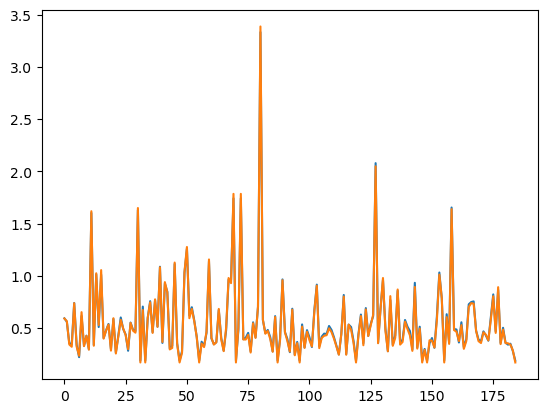

In [89]:
import matplotlib.pyplot as plt 
plt.plot(modD)
plt.plot(nomodD)
plt.show() ####### extremely alike.

In [91]:
mods = []
nomods = []
for note in range(185):
    if modD[note] > nomodD[note]:
        nomods += [note]
    else:
        mods += [note]

In [92]:
print(mods)

[1, 6, 7, 11, 13, 14, 15, 20, 24, 26, 30, 34, 37, 40, 41, 45, 49, 50, 58, 59, 60, 63, 66, 67, 69, 71, 72, 79, 80, 81, 92, 101, 113, 126, 130, 133, 136, 149, 151, 154, 161, 172, 173, 177, 181, 183]


In [93]:
print(nomods)

[0, 2, 3, 4, 5, 8, 9, 10, 12, 16, 17, 18, 19, 21, 22, 23, 25, 27, 28, 29, 31, 32, 33, 35, 36, 38, 39, 42, 43, 44, 46, 47, 48, 51, 52, 53, 54, 55, 56, 57, 61, 62, 64, 65, 68, 70, 73, 74, 75, 76, 77, 78, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 152, 153, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 178, 179, 180, 182, 184]
